__Author: Peter Kicsiny__

Tested with Xsuite versions:
- xobjects: 0.4.5 
- xtrack: 0.70.3 
- xfields: 0.21.3 
- xpart: 0.19.3

In [1]:
import xobjects as xo
import xtrack as xt
import xfields as xf
import xpart as xp
import numpy as np
from matplotlib import pyplot as plt
import scipy.constants as cst
import time
import os
import pandas as pd
import re
import matplotlib
matplotlib.rcParams['font.size'] = 32
matplotlib.rcParams['figure.subplot.left'] = 0.18
matplotlib.rcParams['figure.subplot.bottom'] = 0.16
matplotlib.rcParams['figure.subplot.right'] = 0.92
matplotlib.rcParams['figure.subplot.top'] = 0.9
matplotlib.rcParams['figure.figsize'] = (12,8)

print(xo.__version__, xt.__version__, xf.__version__, xp.__version__)

0.4.5 0.70.3 0.23.0 0.19.3


To compute the Fourier transform of the turn-by-turn trajectories and find the most dominant peak the harpy package can be used: https://gitlab.cern.ch/jcoellod/harpy.git

This can be downloaded and linked to python with the below cell. Replace the path with the one on your computer.

In [1]:
import sys
sys.path.append("/Users/pkicsiny/phd/cern/git/harpy")
import harmonic_analysis as ha

In [2]:
ha.__file__

'/Users/pkicsiny/phd/cern/git/harpy/harmonic_analysis.py'

Define FCC-ee ttbar parameters.

In [3]:
beam_params = {
"q_b1"                : -1,  # [e]
"q_b2"                : 1,  #  [e]
"bunch_intensity"     : 1.51e11,  # [1]
"energy"              : 45.6,  # [GeV]
"p0c"                 : 45.6*1e9,  # [eV]
"mass0"               : 511000,  # [eV]
"phi"                 : 15e-3,  # [rad] half crossing angle
"alpha"               : 0,  # [rad] crossing plane
"u_sr"                : 0.0394,  # [GeV]
"qx"                  : 0.54,  # [1] superperiod tune
"qy"                  : 0.55,  # [1]
"qs"                  : 0.0072,  # [1]
"physemit_x"          : 7.1e-10, # [m]
"physemit_y"          : 7.5e-13,  # [m]
"beta_x"              : 0.11,  # [m]
"beta_y"              : 0.0007,  # [m]
"sigma_z"             : 5.6e-3,  # [m] sr
"sigma_z_bs"          : 12.7e-3,  # [m] sr+bs
"sigma_delta"         : 3.9e-4,  # [1]
"sigma_delta_bs"      : 8.9e-4,  # [1] sr+bs
"n_ip"                : 4,  # [1]
"k2_factor" : 0.7,  # [1] crab-waist strength scaling factor
}
    
beam_params["sigma_x" ] = np.sqrt(beam_params["physemit_x"]*beam_params["beta_x"])  # [m]
beam_params["sigma_px"] = np.sqrt(beam_params["physemit_x"]/beam_params["beta_x"])  # [1]
beam_params["sigma_y" ] = np.sqrt(beam_params["physemit_y"]*beam_params["beta_y"])  # [m]
beam_params["sigma_py"] = np.sqrt(beam_params["physemit_y"]/beam_params["beta_y"])  # [1]
beam_params["beta_s"]        = beam_params["sigma_z"]/beam_params["sigma_delta"]  # [m]
beam_params["physemit_s"]    = beam_params["sigma_z"]*beam_params["sigma_delta"]  # [m]
beam_params["beta_s_bs"]     = beam_params["sigma_z_bs"]/beam_params["sigma_delta_bs"]  # [m]
beam_params["physemit_s_bs"] = beam_params["sigma_z_bs"]*beam_params["sigma_delta_bs"]  # [m]
beam_params["gamma"]         = beam_params[    "energy"] /(beam_params["mass0"]*1e-9)  # [1]


Simulate some turns.

In [4]:
n_turns = 2**10
n_turns

1024

Define a test grid of particles extending to $6\sigma_{x,y}$ and all other dynamical variables are set to 0.

In [5]:
context = xo.ContextCpu(omp_num_threads=8)

n_j = 100 # number of grid points in x and y
j_max = 3 # maximum extent in action space

# logarithmic spacing of grid points to have better resolution for small amplitudes
j_vec_x = np.linspace(0,j_max, n_j)**2/2
j_vec_y = np.linspace(0,j_max, n_j)**2/2

# smallest amplitude particle (if x,y=0, no interaction)
j_vec_x[0] = 1e-4
j_vec_y[0] = 1e-4

# convert into x,y space
x_test_vec = np.sqrt(2*j_vec_x)
y_test_vec = np.sqrt(2*j_vec_y)

# create mesh of particles in x and y
test_coords = [(x_test, y_test) for x_test in x_test_vec for y_test in y_test_vec]
x_arr = np.array([xys[0] for xys in test_coords])
y_arr = np.array([xys[1] for xys in test_coords])

# 0 values for other dynamical variables
empty_coord_vec = np.zeros(len(x_test_vec)*len(y_test_vec))

# create particle grid
test_grid = xp.Particles(
             _context = context, 
            q0        = -1,
            p0c       = beam_params["p0c"],
            mass0     = beam_params["mass0"],
                     x= beam_params["sigma_x"]*x_arr,
                     y= beam_params["sigma_y"]*y_arr,
                  zeta=empty_coord_vec,
                    px=empty_coord_vec,
                    py=empty_coord_vec,
                 delta=empty_coord_vec,
                 weight=1)
n_macroparticles = test_grid._capacity

# save initial coordinates for amplitude space plot of fma
xx = test_grid.x/beam_params["sigma_x"]
yy = test_grid.y/beam_params["sigma_y"]

print(n_macroparticles)

10000


Text(0, 0.5, 'y [σy]')

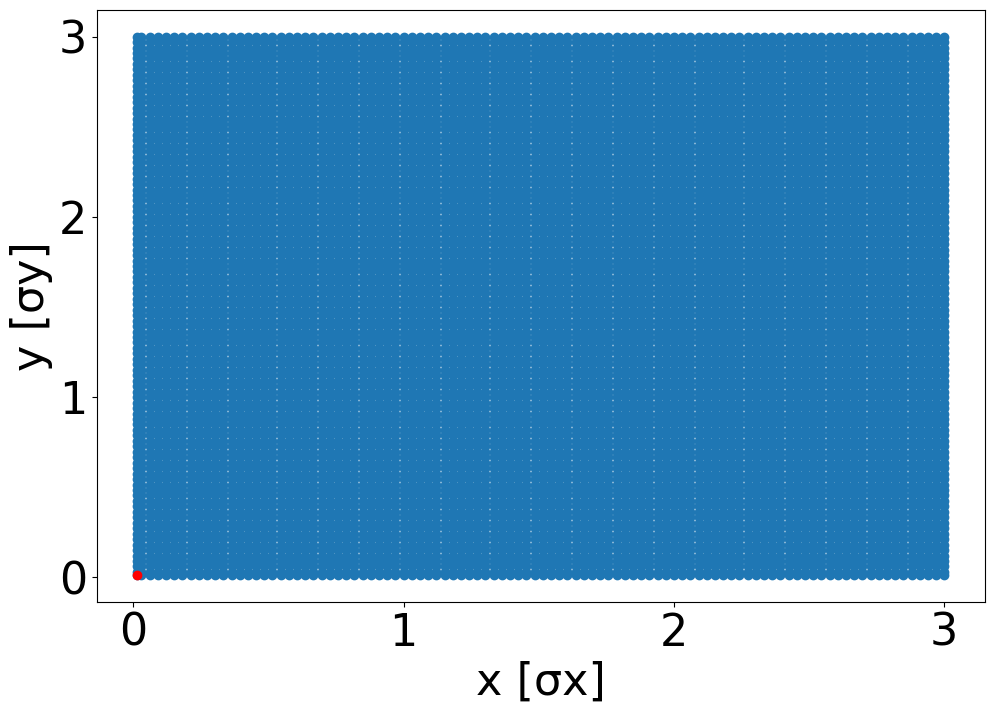

In [6]:
plt.plot(test_grid.x/beam_params["sigma_x"], test_grid.y/beam_params["sigma_y"], "o")
plt.plot(test_grid.x[0]/beam_params["sigma_x"], test_grid.y[0]/beam_params["sigma_y"], "ro")

plt.xlabel("x [σx]")
plt.ylabel("y [σy]")

Setup lonear arc with the crab sextupoles.

In [7]:
beta_x_sext_left  = 3
beta_y_sext_left  = 500
beta_x_sext_right = 3
beta_y_sext_right = 500

alpha_x_sext_left  = 0
alpha_y_sext_left  = 0
alpha_x_sext_right = 0
alpha_y_sext_right = 0

# from IP to right crab sextupole
el_arc_left_b1 = xt.LineSegmentMap(_context=context,
    qx = 0,  # 2pi phase advance so integer part is zero
    qy = 0.25,  # 2.5pi
    qs = 0,  # no dipole here so no synchrotron motion
    betx = [beam_params["beta_x"], beta_x_sext_left],
    bety = [beam_params["beta_y"], beta_y_sext_left],
    alfx = [0, alpha_x_sext_left],
    alfy = [0, alpha_y_sext_left],
    bets = beam_params["beta_s"],
)

el_arc_mid_b1 = xt.LineSegmentMap(_context=context,
    qx =  beam_params["qx"], 
    qy =  beam_params["qy"] -.5 , # subtract .25*2 phase advance from small arcs
    qs =  beam_params["qs"],
    betx = [beta_x_sext_left, beta_x_sext_right],
    bety = [beta_y_sext_left, beta_y_sext_right],
    alfx = [alpha_x_sext_left, alpha_x_sext_right],
    alfy = [alpha_y_sext_left, alpha_y_sext_right],
    bets = beam_params["beta_s"],
)

# from left crab sextupole to IP2
el_arc_right_b1 = xt.LineSegmentMap(_context=context,
    qx = 0,  # 2pi phase advance so integer part is zero
    qy = 0.25,  # 2.5pi
    qs = 0,  # no dipole here so no synchrotron motion
    betx = [beta_x_sext_right, beam_params["beta_x"]],
    bety = [beta_y_sext_right, beam_params["beta_y"]],
    alfx = [alpha_x_sext_right, 0],
    alfy = [alpha_y_sext_right, 0],
    bets = beam_params["beta_s"],
)

# injection from initial distribution to right sextupole
el_inject_b1 = xt.LineSegmentMap(_context=context,
    betx = [beam_params["beta_x"], beta_x_sext_right],
    bety = [beam_params["beta_y"], beta_y_sext_right],
    alfx = [0, alpha_x_sext_right],
    alfy = [0, alpha_y_sext_right],
    bets = beam_params["beta_s"],
)

k2_left  = beam_params["k2_factor"] / (2 * beam_params["phi"] * beam_params["beta_y"] * beta_y_sext_left ) * np.sqrt(beam_params["beta_x"] / beta_x_sext_left )
k2_right = beam_params["k2_factor"] / (2 * beam_params["phi"] * beam_params["beta_y"] * beta_y_sext_right) * np.sqrt(beam_params["beta_x"] / beta_x_sext_right)

el_sextupole_left  = xt.Multipole(order=2, knl=[0, 0,   k2_left])
el_sextupole_right = xt.Multipole(order=2, knl=[0, 0, -k2_right])

Set up the beam-beam element.

In [8]:
n_slices = 100
slicer = xf.TempSlicer(_context=context, n_slices=n_slices, sigma_z=beam_params["sigma_z_bs"], mode="unicharge")

el_beambeam_b1 = xf.BeamBeamBiGaussian3D(
        _context=context,
    
        ########################################################################
        # this is the charge in units of elementary charges of the strong beam #
        ########################################################################
    
        other_beam_q0=1,
    
        ##################################################################
        # phi=crossing angle in radians, alpha=crossing plane in radians #
        ##################################################################
    
        phi=beam_params["phi"],
        alpha=0,

        ###############################################################################
        # slice intensity [num. real particles] n_slices inferred from length of this #
        ###############################################################################
    
        slices_other_beam_num_particles = slicer.bin_weights * beam_params["bunch_intensity"],
    
        ######################################
        # unboosted strong bunch RMS moments #
        ######################################
    
        slices_other_beam_Sigma_11    = n_slices*[beam_params["sigma_x"]**2],
        slices_other_beam_Sigma_22    = n_slices*[beam_params["sigma_px"]**2],
        slices_other_beam_Sigma_33    = n_slices*[beam_params["sigma_y"]**2],
        slices_other_beam_Sigma_44    = n_slices*[beam_params["sigma_py"]**2],
        
        # no x-y coupling now
        slices_other_beam_Sigma_12    = n_slices*[0],
        slices_other_beam_Sigma_34    = n_slices*[0],
        
        ###############################
        # only if beamstrahlung is on #
        ###############################
        
        # these can be hidden from the user in the future
        slices_other_beam_zeta_center = slicer.bin_centers,
        slices_other_beam_zeta_bin_width_star_beamstrahlung = slicer.bin_widths_beamstrahlung / np.cos(beam_params["phi"]),  # boosted dz

)

{'digitize': <xobjects.context.Kernel object at 0x112e0c940>, 'compute_slice_moments': <xobjects.context.Kernel object at 0x112e0cbb0>, 'compute_slice_moments_cuda_sums_per_slice': <xobjects.context.Kernel object at 0x112e0ce80>, 'compute_slice_moments_cuda_moments_from_sums': <xobjects.context.Kernel object at 0x112e0d030>}
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


Set up the xtrack line with one monitor to record the turn-by-turn coordinates.

In [9]:
monitor_coords_b1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=n_turns, particle_id_range=(0,test_grid._capacity))

line = xt.Line(elements = [
                          monitor_coords_b1,
                          el_sextupole_right,
                          el_arc_right_b1,
                          el_beambeam_b1,
                          el_arc_left_b1,
                          el_sextupole_left,
                          el_arc_mid_b1,
])

line.build_tracker(_context=context)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


Settings for the FFT.
- `fma_chunk_size`: size of the sliding window in number of turns, based on which the partial tunes for the FMA are computed.
- `fma_step_size`: frequency in number of turns to compute the partial tunes with the sliding window
- `fma_counter`: counter for the number of partial tunes computed over the tracking
- `chunk_id`: integer to name the files contaning the partial tunes

In [10]:
fma_chunk_size = int(n_turns / 2)
fma_step_size = int(n_turns*0.05)  # results in 1/(2*f)+1 points, here f=0.05
fma_counter = 1
chunk_id = 0

These are a few utility functions to analytically estimate the incoherent tune shift and to compute the FFT of the turn-by-turn trajectories and find the most dominant peak on the spectrum using harpy.

In [11]:
def do_fft_dump(coords_buffer, qx, qy, qx_i_anal, qy_i_anal, n_macroparts, n_turns, fname_idx=0, window=3, laskar=True, laskar_n_peaks=2, laskar_lower=.9, laskar_upper=1.2, out_path="../outputs/fma", out_name=None, alpha_x=0, alpha_y=0, beta_x=0, beta_y=0):
    """
    :param coords_buffer: dict or pandas dataframe. If df each column is a series of length n_turns. 
    If dict each value is an np array of shape (n_macroparticles, n_turns)
    :param qx, qy (float): nominal tunes in units of [2pi]. Full turn tune for nonlinear lattice, superperiod tune for linear tracking.
    :param qx_i_anal, qy_i_anal (float): analytical incoherent tunes in units of [2pi]. Full turn tune for nonlinear lattice, superperiod tune for linear tracking. If there is no beambeam in the simulation, use q_i_anal=q.
    """
        
    #normalize    
    if beta_x > 0:
        coords_buffer = normalize_phase_space(coords_buffer, alpha_x=alpha_x, alpha_y=alpha_y, beta_x=beta_x, beta_y=beta_y)
        key_x, key_y, key_px, key_py = "x_norm", "y_norm", "px_norm", "py_norm"
    else:
        key_x, key_y, key_px, key_py = infer_buffer_type(coords_buffer)      
        
    print("Computing tune spectra...")
    q_rel, fft_x_single_part, fft_y_single_part, qx_i_sim, qy_i_sim = do_fft(coords_buffer, n_macroparts, n_turns,
                                                                      qx, qy,
                                                                      qx_i_anal, qy_i_anal,
                                                                      window=window, 
                                                                      laskar=laskar,
                                                                      laskar_n_peaks=laskar_n_peaks,
                                                                      key_x=key_x, key_y=key_y, laskar_lower=laskar_lower, laskar_upper=laskar_upper)
    # write running tunes
    print(f"Saving incoherent tunes to {out_path}")
    if out_name is None:
        fname = os.path.join(out_path, "q_i_sim_{}.txt".format(np.char.zfill(str(fname_idx),3)))
    else:
        fname = os.path.join(out_path, out_name)
    np.savetxt(fname, np.c_[qx_i_sim, qy_i_sim], header="qx_i_sim qy_i_sim")

def do_fft(coords_dict, n_macroparts, n_turns, bare_tunes, incoherent_tunes, window=3, laskar=True, laskar_n_peaks=2, key_x="x", key_y="y", key_s="zeta", laskar_lower=.95, laskar_upper=1.2):
    """
    :param coords_dict (dict): contains particle trajectories. Keys are dynamical variables, values are np arrays of shape (n_macroparticles, n_turns).
    :param qx, qy (float): nominal fractional tunes in units of [2pi]. Typically the full turn tune with full lattice tracking and tune per superperiod for linear tracking.
    :param qx_i_anal, qy_i_anal (float): fractional incoherent tunes in units of [2pi]. Tune of a small amplitude particle. Typically the full turn tune with full lattice tracking and tune per superperiod for linear tracking.
    :param laskar (bool): find peaks with laskar method i.e. interpolation, see: [Application of frequency map analysis to the ALS, J. Laskar] (true) OR by selecting the largest amplitude FFT channel (false)
    :param window (int): if 'laskar'=False, search for the FFT peak in the neighborhood [q_i_anal_idx-window, q_i_anal_idx+window[, where 'q_i_anal_idx' is the FFT channel (array index) of the peak of the analytical incoherent tune. Accuracy of peak is 1/n_turns.
    :param laskar_n_peaks (int): if 'laskar'=True, select this many largest amplitude peaks from the spectrum. Usually even number as the FFT spectrum is symmetric to 0.5, so there are 2 copies of each peak. Accuracy of peak is 1/n_turns**4.
    :param laskar_lower, laskar_upper (float): from the 'laskar_n_peaks' peaks found by the laskar method, trigger on those within the window [q-lower, q_i_anal+upper], i.e. between the nominal and analytical beam-beam incoherent tunes.
    """    
    
    if len(bare_tunes) == 2 and len(incoherent_tunes) == 2:
        qx, qy = bare_tunes
        qx_i_anal, qy_i_anal = incoherent_tunes
        do_qs = False
    elif len(bare_tunes) == 3 and len(incoherent_tunes) == 3:
        qx, qy, qs = bare_tunes
        qx_i_anal, qy_i_anal, qs_i_anal = incoherent_tunes
        do_qs = True
    else:
        raise ValueError("tunes tuple length has to be either 2 or 3")
    
    coords_x = np.reshape(coords_dict[key_x], (n_macroparts, n_turns))
    coords_y = np.reshape(coords_dict[key_y], (n_macroparts, n_turns))
    if do_qs:
        coords_s = np.reshape(coords_dict[key_s], (n_macroparts, n_turns))
    
    length = n_macroparts  # number of macroparticles
    fft_resolution = n_turns  # fft resolution is equal to the number of time samples
    fft_x_single_part = np.zeros((length, fft_resolution))  # tune spectrum x
    fft_y_single_part = np.zeros((length, fft_resolution))  # tune spectrum y
    if do_qs:
        fft_s_single_part = np.zeros((length, fft_resolution))  # tune spectrum s

    qx_i_sim = np.zeros((length))  # incoherent tune peak x
    qy_i_sim = np.zeros((length))  # incoherent tune peak y
    if do_qs:
        qs_i_sim = np.zeros((length))  # incoherent tune peak s
    
    ##############
    # fft x axis #
    ##############
    
    if qx_i_anal>.5:
        qx_rel = np.fft.fftshift(np.fft.fftfreq(fft_resolution))
    else:
        qx_rel = np.fft.fftfreq(fft_resolution)
        
    if qy_i_anal>.5:
        qy_rel = np.fft.fftshift(np.fft.fftfreq(fft_resolution))
    else:
        qy_rel = np.fft.fftfreq(fft_resolution)

    if do_qs:
        if qs_i_anal>.5:
            qs_rel = np.fft.fftshift(np.fft.fftfreq(fft_resolution))
        else:
            qs_rel = np.fft.fftfreq(fft_resolution)

        
    # get spectrum of all particle trajectories
    for part_i in range(length):
        
        if qx_i_anal>.5:
            fft_x_single_part[part_i]  = np.log10(np.abs(np.fft.fft(coords_x[part_i])))
        else:
            fft_x_single_part[part_i]  = np.log10(np.abs(np.fft.fftshift(np.fft.fft(coords_x[part_i]))))

        if qy_i_anal>.5:
            fft_y_single_part[part_i]  = np.log10(np.abs(np.fft.fft(coords_y[part_i])))
        else:
            fft_y_single_part[part_i]  = np.log10(np.abs(np.fft.fftshift(np.fft.fft(coords_y[part_i]))))

        if do_qs:
            if qs_i_anal>.5:
                fft_s_single_part[part_i]  = np.log10(np.abs(np.fft.fft(coords_s[part_i])))
            else:
                fft_s_single_part[part_i]  = np.log10(np.abs(np.fft.fftshift(np.fft.fft(coords_s[part_i]))))
            
        
        ################################
        # find shifted incoherent tune #
        ################################
        
        if laskar:
            
            # better approximation with Laskar frequency analysis: https://link.springer.com/content/pdf/10.1007/BF00699731.pdf
            fft_harpy_x_single_part = ha.HarmonicAnalysis(coords_x[part_i])
            fft_harpy_y_single_part = ha.HarmonicAnalysis(coords_y[part_i])
            if do_qs:
                fft_harpy_s_single_part = ha.HarmonicAnalysis(coords_s[part_i])

            f_x_single_part, coeff_x_single_part = fft_harpy_x_single_part.laskar_method(laskar_n_peaks)
            f_y_single_part, coeff_y_single_part = fft_harpy_y_single_part.laskar_method(laskar_n_peaks)
            if do_qs:
                f_s_single_part, coeff_s_single_part = fft_harpy_s_single_part.laskar_method(laskar_n_peaks)

            if qx>=.5:
                coeff_x_single_part = np.array(coeff_x_single_part)[(np.array(f_x_single_part)>=.5)]
                f_x_single_part     = np.array(    f_x_single_part)[(np.array(f_x_single_part)>=.5)]
            else:
                coeff_x_single_part = np.array(coeff_x_single_part)[(np.array(f_x_single_part)<.5)]
                f_x_single_part     = np.array(    f_x_single_part)[(np.array(f_x_single_part)<.5)]
                
            if qy>=.5:
                coeff_y_single_part = np.array(coeff_y_single_part)[(np.array(f_y_single_part)>=.5)]
                f_y_single_part     = np.array(    f_y_single_part)[(np.array(f_y_single_part)>=.5)]
            else:
                coeff_y_single_part = np.array(coeff_y_single_part)[(np.array(f_y_single_part)<.5)]
                f_y_single_part     = np.array(    f_y_single_part)[(np.array(f_y_single_part)<.5)]

            if do_qs:
                if qs>=.5:
                    coeff_s_single_part = np.array(coeff_s_single_part)[(np.array(f_s_single_part)>=.5)]
                    f_s_single_part     = np.array(    f_s_single_part)[(np.array(f_s_single_part)>=.5)]
                else:
                    coeff_s_single_part = np.array(coeff_s_single_part)[(np.array(f_s_single_part)<.5)]
                    f_s_single_part     = np.array(    f_s_single_part)[(np.array(f_s_single_part)<.5)]
            
            coeff_x_single_part = np.array(coeff_x_single_part)[(np.array(f_x_single_part)>=qx*laskar_lower) & (np.array(f_x_single_part)<=qx_i_anal*laskar_upper)]
            coeff_y_single_part = np.array(coeff_y_single_part)[(np.array(f_y_single_part)>=qy*laskar_lower) & (np.array(f_y_single_part)<=qy_i_anal*laskar_upper)]
            if do_qs:
                coeff_s_single_part = np.array(coeff_s_single_part)[(np.array(f_s_single_part)>=qs*laskar_lower) & (np.array(f_s_single_part)<=qs_i_anal*laskar_upper)]

            f_x_single_part = np.array(f_x_single_part)[(np.array(f_x_single_part)>=qx*laskar_lower) & (np.array(f_x_single_part)<=qx_i_anal*laskar_upper)]
            f_y_single_part = np.array(f_y_single_part)[(np.array(f_y_single_part)>=qy*laskar_lower) & (np.array(f_y_single_part)<=qy_i_anal*laskar_upper)]
            if do_qs:
                f_s_single_part = np.array(f_s_single_part)[(np.array(f_s_single_part)>=qs*laskar_lower) & (np.array(f_s_single_part)<=qs_i_anal*laskar_upper)]
            
            #print(part_i, f_y_single_part, np.abs(coeff_y_single_part), "\n")

            ##############################################################################################
            # take peak that is closest to the analytical incoherent tune computed with formulas outside #
            ##############################################################################################
            
            if len(f_x_single_part)>0:
                qx_i_sim[part_i] = f_x_single_part[np.argmax(np.abs(coeff_x_single_part))]
                #qx_i_sim[part_i] = f_x_single_part[np.argmin(np.abs(np.array(f_x_single_part)-(qx_i_anal)))]
            else: 
                qx_i_sim[part_i] = 0
                
            if len(f_y_single_part)>0:
                qy_i_sim[part_i] = f_y_single_part[np.argmax(np.abs(coeff_y_single_part))]
                #qy_i_sim[part_i] = f_y_single_part[np.argmin(np.abs(np.array(f_y_single_part)-(qy_i_anal)))]
            else:
                qy_i_sim[part_i] = 0 

            if do_qs:
                if len(f_s_single_part)>0:
                    qs_i_sim[part_i] = f_s_single_part[np.argmax(np.abs(coeff_s_single_part))]
                    #qs_i_sim[part_i] = f_s_single_part[np.argmin(np.abs(np.array(f_s_single_part)-(qs_i_anal)))]
                else:
                    qs_i_sim[part_i] = 0 
        
        ###################
        # dont use laskar #
        ###################
        
        else:
            
            # conversion from tune value to fft channel idx
            qx_i_anal_idx_in_fft = (qx_i_anal*fft_resolution + fft_resolution/2)
            qy_i_anal_idx_in_fft = (qy_i_anal*fft_resolution + fft_resolution/2)
            if do_qs:
                qs_i_anal_idx_in_fft = (qs_i_anal*fft_resolution + fft_resolution/2)
        
            # take peak that is closest to the analytical incoherent tune computed with formulas outside
            qx_i_sim_idx_in_fft = int(qx_i_anal_idx_in_fft)-window + np.argmax(fft_x_single_part[part_i][int(qx_i_anal_idx_in_fft)-window:int(qx_i_anal_idx_in_fft)+window])
            qy_i_sim_idx_in_fft = int(qy_i_anal_idx_in_fft)-window + np.argmax(fft_y_single_part[part_i][int(qy_i_anal_idx_in_fft)-window:int(qy_i_anal_idx_in_fft)+window])
            if do_qs:
                qs_i_sim_idx_in_fft = int(qs_i_anal_idx_in_fft)-window + np.argmax(fft_s_single_part[part_i][int(qs_i_anal_idx_in_fft)-window:int(qs_i_anal_idx_in_fft)+window])

            # simulated incoherent tune from vanilla fft
            qx_i_sim[part_i] = qx_rel[qx_i_sim_idx_in_fft]
            qy_i_sim[part_i] = qy_rel[qy_i_sim_idx_in_fft]
            if do_qs:
                qs_i_sim[part_i] = qs_rel[qs_i_sim_idx_in_fft]
    
    if do_qs:
        return qx_rel, qy_rel, qs_rel, fft_x_single_part, fft_y_single_part, fft_s_single_part, qx_i_sim, qy_i_sim, qs_i_sim  # these arrays of length n_macroparts
    else:
        return qx_rel, qy_rel, fft_x_single_part, fft_y_single_part, qx_i_sim, qy_i_sim  # these arrays of length n_macroparts

def compute_dq_anal(beam_params, yokoya=1.3, m_0=cst.m_e, sigma_z_key="sigma_z_bs", sigma_y_key="sigma_y", beta_s_key="beta_s_bs"):

    tunes = {}
    
    # particle radius
    r0 = -beam_params["q_b1"]*beam_params["q_b2"]*cst.e**2/(4*np.pi*cst.epsilon_0*m_0*cst.c**2) # - if pp
    
    # geometric reduction factor, piwinski angle
    phi_x = np.arctan(np.tan(beam_params["phi"])*np.cos(beam_params["alpha"]))
    phi_y = np.arctan(np.tan(beam_params["phi"])*np.sin(beam_params["alpha"]))
    
    piwi_x = beam_params[sigma_z_key]/beam_params[  "sigma_x"]*np.tan(phi_x)
    piwi_y = beam_params[sigma_z_key]/beam_params[sigma_y_key]*np.tan(phi_y)
    
    geometric_factor_x = np.sqrt(1 + piwi_x**2)
    geometric_factor_y = np.sqrt(1 + piwi_y**2)
    
    # get exact ξ with formula, when far from res. it is the tune shift (to incoherent mode) for each parameter in parameter scan
    tunes["xi_x"] = beam_params["bunch_intensity"]*beam_params["beta_x"]*r0 / (2*np.pi*beam_params["gamma"]) / \
    (beam_params["sigma_x"]*geometric_factor_x* \
    (beam_params["sigma_x"]*geometric_factor_x + beam_params[sigma_y_key]*geometric_factor_y))
    
    tunes["xi_y"] = beam_params["bunch_intensity"]*beam_params["beta_y"]*r0 / (2*np.pi*beam_params["gamma"]) / \
    (beam_params[sigma_y_key]*geometric_factor_y* \
    (beam_params["sigma_x"]*geometric_factor_x + beam_params[sigma_y_key]*geometric_factor_y))
    
    tunes["xi_s"] = beam_params["bunch_intensity"]*beam_params[beta_s_key]*np.tan(phi_x)**2*r0 / (2*np.pi*beam_params["gamma"]) / \
    (beam_params["sigma_x"]*geometric_factor_x* \
    (beam_params["sigma_x"]*geometric_factor_x + beam_params[sigma_y_key]*geometric_factor_y))
    
    #print("xi_x: {}\nxi_y: {}".format(tunes["xi_x"], tunes["xi_y"]))
    
    # get analytical incoherent tune, plug in exact ξ from previous
    if beam_params["qx"]-int(beam_params["qx"]) <.5:
        tunes["qx_i_anal"] = (np.arccos(np.cos(2*np.pi*beam_params["qx"]) - 2*np.pi*tunes["xi_x"]*np.sin(2*np.pi*beam_params["qx"])))/(2*np.pi)
    else:
        tunes["qx_i_anal"] = 1 - (np.arccos(np.cos(2*np.pi*beam_params["qx"]) - 2*np.pi*tunes["xi_x"]*np.sin(2*np.pi*beam_params["qx"])))/(2*np.pi)
        
    if beam_params["qy"]-int(beam_params["qy"]) <.5:
        tunes["qy_i_anal"] = (np.arccos(np.cos(2*np.pi*beam_params["qy"]) - 2*np.pi*tunes["xi_y"]*np.sin(2*np.pi*beam_params["qy"])))/(2*np.pi)
    else:
        tunes["qy_i_anal"] = 1 - (np.arccos(np.cos(2*np.pi*beam_params["qy"]) - 2*np.pi*tunes["xi_y"]*np.sin(2*np.pi*beam_params["qy"])))/(2*np.pi)

    if beam_params["qs"]-int(beam_params["qs"]) <.5:
        tunes["qs_i_anal"] = (np.arccos(np.cos(2*np.pi*beam_params["qs"]) - 2*np.pi*tunes["xi_s"]*np.sin(2*np.pi*beam_params["qs"])))/(2*np.pi)
    else:
        tunes["qs_i_anal"] = 1 - (np.arccos(np.cos(2*np.pi*beam_params["qs"]) - 2*np.pi*tunes["xi_s"]*np.sin(2*np.pi*beam_params["qs"])))/(2*np.pi)
        
        
    # get analytical tune shift (equals ξ when far from resonance)
    tunes["dqx_anal"] = tunes["qx_i_anal"] - beam_params["qx"]
    tunes["dqy_anal"] = tunes["qy_i_anal"] - beam_params["qy"]
    tunes["dqs_anal"] = tunes["qs_i_anal"] - beam_params["qs"]
    
    # analytical pi mode corrected by yokoya
    tunes["qx_pi_anal"] = beam_params["qx"]+yokoya*tunes["dqx_anal"]
    tunes["qy_pi_anal"] = beam_params["qy"]+yokoya*tunes["dqy_anal"]
    tunes["qs_pi_anal"] = beam_params["qs"]+yokoya*tunes["dqs_anal"]
    
    return tunes


tunes = compute_dq_anal(beam_params, yokoya=1.3, m_0=cst.m_e, sigma_z_key="sigma_z_bs")


Do the tracking. The monitor will record the turn-by-turn coordinates and the if condition will trigger periodically to compute the running tunes using the sliding window on a fraction of the trajectories.

In [15]:
import heapq

In [16]:
x = [3, 2, 3, 1, 2, 4, 5, 5, 6]
heapq.heapify(x)
x

[1, 2, 3, 2, 3, 4, 5, 5, 6]

In [12]:
out_path = "partial_tunes"
bare_tunes = (beam_params["qx"], beam_params["qy"])
incoherent_tunes = (tunes["qx_i_anal"], tunes["qy_i_anal"])

el_inject_b1.track(test_grid)
for turn in range(n_turns):
    
    ################
    # track 1 turn #
    ################
    
    start_time = time.time()
    line.track(test_grid, num_turns=1)
    time_elapsed = time.time() - start_time

    ########################################################
    # compute partial tunes and save them at turn 9,19,... #
    ########################################################

    if fma_counter==fma_chunk_size:
        fma_counter -= fma_step_size
        chunk_id    = ((turn+1) - fma_chunk_size) / fma_step_size
        chunk_start = int(chunk_id*fma_step_size)
        chunk_end   = int(chunk_id*fma_step_size + fma_chunk_size)
        print(f"Turn {turn+1}: FMA chunk {chunk_id} | coords [{chunk_start}-{chunk_end}[")
        
        # extract transverse coordinates falling into the relevant sliding window from the monitor
        mon_data = monitor_coords_b1.to_dict()["data"]
        coords_dict = {}
        coords_dict["x"]  = np.reshape( mon_data["x"], (n_macroparticles, n_turns))[:,chunk_start:chunk_end]
        coords_dict["y"]  = np.reshape( mon_data["y"], (n_macroparticles, n_turns))[:,chunk_start:chunk_end]
        
        # call utility function
        qx_rel, qy_rel, fft_x_single_part, fft_y_single_part, qx_i_sim, qy_i_sim = do_fft(coords_dict, test_grid._capacity, 
                                                                      fma_chunk_size, bare_tunes, incoherent_tunes,
                                                                      laskar_n_peaks=4,
                                                                      )
        # write running tunes
        print(f"Saving incoherent partial tunes to {out_path}")
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        fname = os.path.join(out_path, "q_i_sim_{}.txt".format(np.char.zfill(str(chunk_id),3)))
        np.savetxt(fname, np.c_[qx_i_sim, qy_i_sim], header="qx_i_sim qy_i_sim")
    

    fma_counter +=1

    print(f"Done tracking for 1 turn [{turn+1}/{n_turns}]: {time_elapsed:.4f} [s]")
    

{'LineSegmentMap_track_particles': <xobjects.context.Kernel object at 0x10f4284f0>}
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Done tracking for 1 turn [1/1024]: 0.1666 [s]
Done tracking for 1 turn [2/1024]: 0.0953 [s]
Done tracking for 1 turn [3/1024]: 0.1046 [s]
Done tracking for 1 turn [4/1024]: 0.1021 [s]
Done tracking for 1 turn [5/1024]: 0.0880 [s]
Done tracking for 1 turn [6/1024]: 0.0870 [s]
Done tracking for 1 turn [7/1024]: 0.1383 [s]
Done tracking for 1 turn [8/1024]: 0.0826 [s]
Done tracking for 1 turn [9/1024]: 0.0792 [s]
Done tracking for 1 turn [10/1024]: 0.0912 [s]
Done tracking for 1 turn [11/1024]: 0.0833 [s]
Done tracking for 1 turn [12/1024]: 0.0781 [s]
Done tracking for 1 turn [13/1024]: 0.0907 [s]
Done tracking for 1 turn [14/1024]: 0.0818 [s]
Done tracking for 1 turn [15/1024]: 0.0884 [s]
Done tracking for 1 turn [16/1024]: 0.0915 [s]
Done tracking for 1 turn [17/1024]: 0.0797 [s]
Done tracking for 1 turn [18/1024]: 0.0851 [s]
Done tracking for 1 turn [19/1024]: 0.0973 [s]
Done tracking for 1 turn [20/1024]: 0.0898 [s]
Done tracking for 1 turn [21/1024]

Done tracking for 1 turn [176/1024]: 0.0839 [s]
Done tracking for 1 turn [177/1024]: 0.0860 [s]
Done tracking for 1 turn [178/1024]: 0.0849 [s]
Done tracking for 1 turn [179/1024]: 0.0851 [s]
Done tracking for 1 turn [180/1024]: 0.0896 [s]
Done tracking for 1 turn [181/1024]: 0.0863 [s]
Done tracking for 1 turn [182/1024]: 0.0828 [s]
Done tracking for 1 turn [183/1024]: 0.0788 [s]
Done tracking for 1 turn [184/1024]: 0.0833 [s]
Done tracking for 1 turn [185/1024]: 0.0930 [s]
Done tracking for 1 turn [186/1024]: 0.0848 [s]
Done tracking for 1 turn [187/1024]: 0.0828 [s]
Done tracking for 1 turn [188/1024]: 0.0873 [s]
Done tracking for 1 turn [189/1024]: 0.0820 [s]
Done tracking for 1 turn [190/1024]: 0.0884 [s]
Done tracking for 1 turn [191/1024]: 0.0859 [s]
Done tracking for 1 turn [192/1024]: 0.0933 [s]
Done tracking for 1 turn [193/1024]: 0.0910 [s]
Done tracking for 1 turn [194/1024]: 0.0867 [s]
Done tracking for 1 turn [195/1024]: 0.0866 [s]
Done tracking for 1 turn [196/1024]: 0.0

Done tracking for 1 turn [349/1024]: 0.2543 [s]
Done tracking for 1 turn [350/1024]: 0.1343 [s]
Done tracking for 1 turn [351/1024]: 0.1059 [s]
Done tracking for 1 turn [352/1024]: 0.1218 [s]
Done tracking for 1 turn [353/1024]: 0.1235 [s]
Done tracking for 1 turn [354/1024]: 0.1294 [s]
Done tracking for 1 turn [355/1024]: 0.0975 [s]
Done tracking for 1 turn [356/1024]: 0.1025 [s]
Done tracking for 1 turn [357/1024]: 0.1152 [s]
Done tracking for 1 turn [358/1024]: 0.1049 [s]
Done tracking for 1 turn [359/1024]: 0.1146 [s]
Done tracking for 1 turn [360/1024]: 0.0969 [s]
Done tracking for 1 turn [361/1024]: 0.1016 [s]
Done tracking for 1 turn [362/1024]: 0.0928 [s]
Done tracking for 1 turn [363/1024]: 0.0859 [s]
Done tracking for 1 turn [364/1024]: 0.0958 [s]
Done tracking for 1 turn [365/1024]: 0.0885 [s]
Done tracking for 1 turn [366/1024]: 0.0862 [s]
Done tracking for 1 turn [367/1024]: 0.1110 [s]
Done tracking for 1 turn [368/1024]: 0.1253 [s]
Done tracking for 1 turn [369/1024]: 0.0

Done tracking for 1 turn [520/1024]: 0.0817 [s]
Done tracking for 1 turn [521/1024]: 0.0750 [s]
Done tracking for 1 turn [522/1024]: 0.0812 [s]
Done tracking for 1 turn [523/1024]: 0.0855 [s]
Done tracking for 1 turn [524/1024]: 0.0783 [s]
Done tracking for 1 turn [525/1024]: 0.0867 [s]
Done tracking for 1 turn [526/1024]: 0.0828 [s]
Done tracking for 1 turn [527/1024]: 0.0835 [s]
Done tracking for 1 turn [528/1024]: 0.0895 [s]
Done tracking for 1 turn [529/1024]: 0.0843 [s]
Done tracking for 1 turn [530/1024]: 0.0872 [s]
Done tracking for 1 turn [531/1024]: 0.0915 [s]
Done tracking for 1 turn [532/1024]: 0.0935 [s]
Done tracking for 1 turn [533/1024]: 0.0868 [s]
Done tracking for 1 turn [534/1024]: 0.0760 [s]
Done tracking for 1 turn [535/1024]: 0.0817 [s]
Done tracking for 1 turn [536/1024]: 0.0858 [s]
Done tracking for 1 turn [537/1024]: 0.0851 [s]
Done tracking for 1 turn [538/1024]: 0.0972 [s]
Done tracking for 1 turn [539/1024]: 0.2601 [s]
Done tracking for 1 turn [540/1024]: 0.0

Done tracking for 1 turn [686/1024]: 0.0883 [s]
Done tracking for 1 turn [687/1024]: 0.0986 [s]
Done tracking for 1 turn [688/1024]: 0.1061 [s]
Done tracking for 1 turn [689/1024]: 0.1578 [s]
Done tracking for 1 turn [690/1024]: 0.1614 [s]
Done tracking for 1 turn [691/1024]: 0.1798 [s]
Done tracking for 1 turn [692/1024]: 0.0854 [s]
Done tracking for 1 turn [693/1024]: 0.1192 [s]
Done tracking for 1 turn [694/1024]: 0.0951 [s]
Done tracking for 1 turn [695/1024]: 0.0865 [s]
Done tracking for 1 turn [696/1024]: 0.0864 [s]
Done tracking for 1 turn [697/1024]: 0.0898 [s]
Done tracking for 1 turn [698/1024]: 0.1013 [s]
Done tracking for 1 turn [699/1024]: 0.0831 [s]
Done tracking for 1 turn [700/1024]: 0.0831 [s]
Done tracking for 1 turn [701/1024]: 0.0821 [s]
Done tracking for 1 turn [702/1024]: 0.0889 [s]
Done tracking for 1 turn [703/1024]: 0.0808 [s]
Done tracking for 1 turn [704/1024]: 0.0848 [s]
Done tracking for 1 turn [705/1024]: 0.0854 [s]
Done tracking for 1 turn [706/1024]: 0.0

Done tracking for 1 turn [852/1024]: 0.0761 [s]
Done tracking for 1 turn [853/1024]: 0.0872 [s]
Done tracking for 1 turn [854/1024]: 0.1001 [s]
Done tracking for 1 turn [855/1024]: 0.0938 [s]
Done tracking for 1 turn [856/1024]: 0.0908 [s]
Done tracking for 1 turn [857/1024]: 0.0860 [s]
Done tracking for 1 turn [858/1024]: 0.0893 [s]
Done tracking for 1 turn [859/1024]: 0.0962 [s]
Done tracking for 1 turn [860/1024]: 0.0903 [s]
Done tracking for 1 turn [861/1024]: 0.0898 [s]
Done tracking for 1 turn [862/1024]: 0.1017 [s]
Done tracking for 1 turn [863/1024]: 0.1018 [s]
Done tracking for 1 turn [864/1024]: 0.0848 [s]
Done tracking for 1 turn [865/1024]: 0.0798 [s]
Done tracking for 1 turn [866/1024]: 0.0817 [s]
Done tracking for 1 turn [867/1024]: 0.0992 [s]
Done tracking for 1 turn [868/1024]: 0.0782 [s]
Turn 869: FMA chunk 7.0 | coords [357-869[
Saving incoherent partial tunes to partial_tunes
Done tracking for 1 turn [869/1024]: 0.0807 [s]
Done tracking for 1 turn [870/1024]: 0.1780 

Done tracking for 1 turn [1019/1024]: 0.0915 [s]
Done tracking for 1 turn [1020/1024]: 0.0790 [s]
Done tracking for 1 turn [1021/1024]: 0.0778 [s]
Turn 1022: FMA chunk 10.0 | coords [510-1022[
Saving incoherent partial tunes to partial_tunes
Done tracking for 1 turn [1022/1024]: 0.0928 [s]
Done tracking for 1 turn [1023/1024]: 0.3559 [s]
Done tracking for 1 turn [1024/1024]: 0.0857 [s]


Compute the tune footprint for the full trajectories.

In [13]:
coords_dict = monitor_coords_b1.to_dict()["data"]
qx_rel, qy_rel, fft_x_single_part, fft_y_single_part, qx_i_sim, qy_i_sim = do_fft(coords_dict, test_grid._capacity, 
                                                                      n_turns, bare_tunes, incoherent_tunes,
                                                                      laskar_n_peaks=4,
                                                                      )

Plot tune footprint. Mark the smallest amplitude coordinate (index 0) which is at the tip of the footprint.

/var/folders/k8/n1p47gfj4l7038wc7cs60m400000gn/T/ipykernel_30448/2536318857.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower left", bbox_to_anchor=(0,1.02), fontsize=24)


Text(0, 0.5, '$\\mathrm{Q_y}$ [1]')

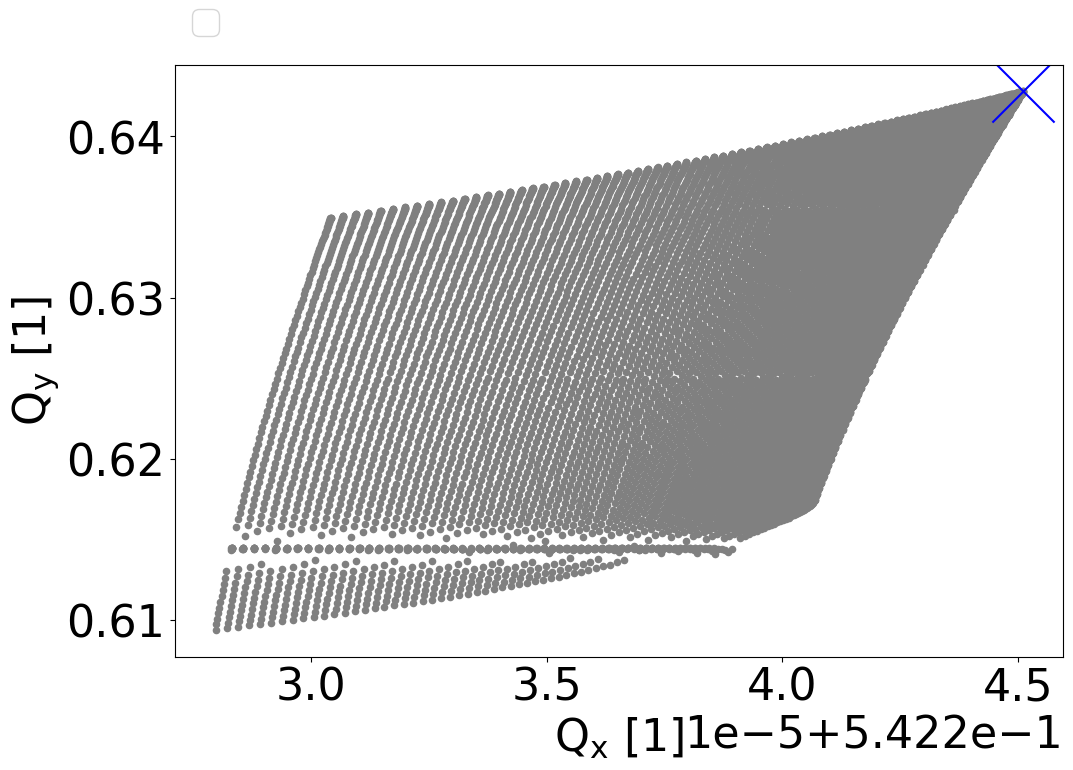

In [14]:
fig, ax = plt.subplots(1,1)
ax.scatter(qx_i_sim,    qy_i_sim,    marker="o", s= 20, c="gray")
ax.scatter(qx_i_sim[0], qy_i_sim[0], marker="x", s=2000, c="b")
ax.legend(loc="lower left", bbox_to_anchor=(0,1.02), fontsize=24)
ax.set_xlabel(r"$\mathrm{Q_x}$ [1]")
ax.set_ylabel(r"$\mathrm{Q_y}$ [1]")

Compute the diffusion parameter which will be plotted as a colormap on the footprint. This can be computed in various ways and here two methods are shown. One method estimates the diffusion from the difference of the first and last partial tunes. The second method estimates it using the r.m.s. of the 10 partial tunes. The diffusion parameter gives an estimate on the change of the single particle tune which can be an indicator of how regular is the particle motion, with a smaller value indicating a more regular trajectory.

In [15]:
# compute diffusion from differences
q_i_sim_files = os.listdir(out_path)
q_i_sim_files = sorted([q_i_sim_file for q_i_sim_file in q_i_sim_files if all([k in q_i_sim_file for k in ["q_i"]])])

q_i_sim_df = pd.DataFrame()
for i, file in enumerate(q_i_sim_files):
    print("[exec.py] reading file:", file)
    chunk_id = int(re.findall("q_i_sim_[0-9]+", file)[0][8:])
    q_i_sim_table = pd.read_table(os.path.join(out_path, file),   delimiter=" ", header=0, escapechar='#')
    q_i_sim_table.index.name = "part_id"
    q_i_sim_table["chunk_id"] = chunk_id
    q_i_sim_table.set_index(["chunk_id"], append=True, inplace=True)
    q_i_sim_df = pd.concat([q_i_sim_df, q_i_sim_table])
diffusion_diff = np.log10(np.sqrt(np.sum((q_i_sim_df.loc[:,0,:,:] - q_i_sim_df.loc[:,10,:,:])**2, axis=1)))

# compute diffusion from rms
q_i_rms_df = pd.DataFrame()
for i in range(1+q_i_sim_df.index.get_level_values(0).max()):
    rms_i = q_i_sim_df.loc[i].std()
    rms = pd.DataFrame(rms_i).T
    q_i_rms_df = pd.concat([q_i_rms_df, rms])
q_i_rms_df.reset_index(inplace=True, drop=True)
diffusion_rms = np.log10(np.sqrt(np.array(q_i_rms_df[" qx_i_sim"])**2 + np.array(q_i_rms_df["qy_i_sim"])**2))

[exec.py] reading file: q_i_sim_0.0.txt
[exec.py] reading file: q_i_sim_1.0.txt
[exec.py] reading file: q_i_sim_10.0.txt
[exec.py] reading file: q_i_sim_2.0.txt
[exec.py] reading file: q_i_sim_3.0.txt
[exec.py] reading file: q_i_sim_4.0.txt
[exec.py] reading file: q_i_sim_5.0.txt
[exec.py] reading file: q_i_sim_6.0.txt
[exec.py] reading file: q_i_sim_7.0.txt
[exec.py] reading file: q_i_sim_8.0.txt
[exec.py] reading file: q_i_sim_9.0.txt


Plot the footprint again but now with the added colormap showing the diffusion parameter. A higher diffusion means a more irregular particle trajectory.

Text(0, 0.5, '$\\mathrm{Q_y}$ [1]')

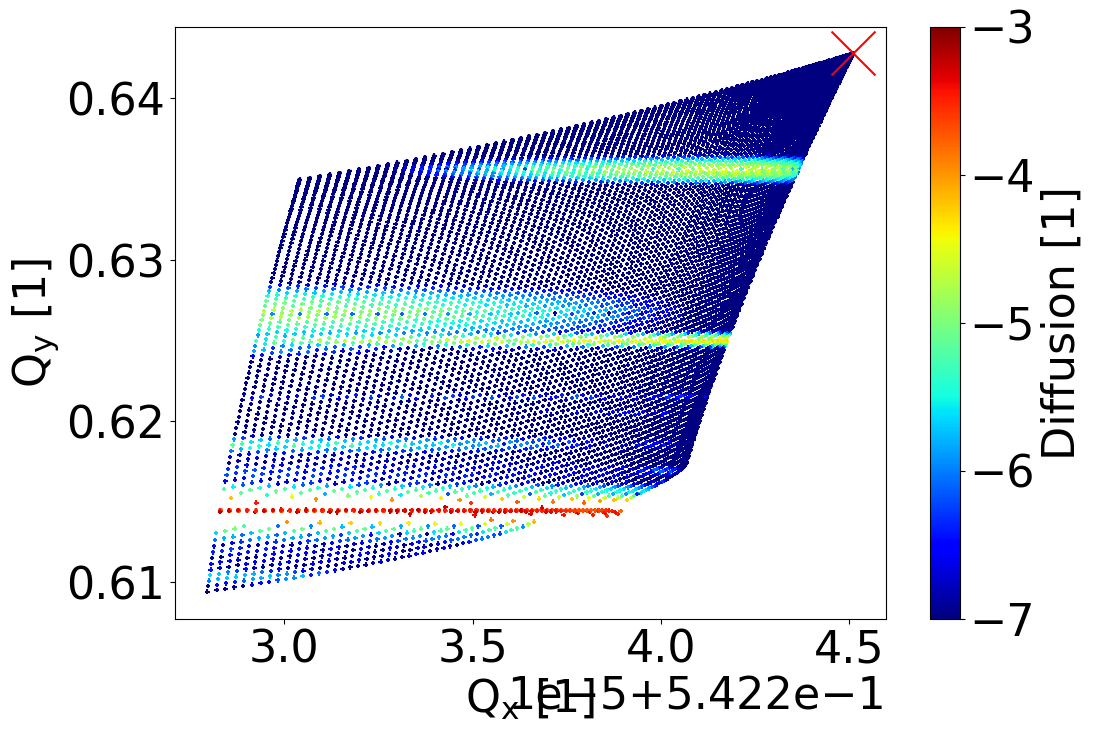

In [16]:
fig, ax = plt.subplots(1,1)
img = ax.scatter(qx_i_sim, qy_i_sim, marker="+", s=10, c=diffusion_rms, vmin=-7, vmax=-3, cmap="jet")
ax.scatter(qx_i_sim[0], qy_i_sim[0], marker="x", s=1000, c="r", label=f"$\mathrm{{Q_{{x,i}}}}$={qx_i_sim[-1]:.5e}")

cbar = fig.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Diffusion [1]")

# axis labels
plt.xlabel(r"$\mathrm{Q_x}$ [1]")
plt.ylabel(r"$\mathrm{Q_y}$ [1]")


In [35]:
fig, ax = plt.subplots(1,1)
img = ax.scatter(xx, yy, marker="o", s=10, c=diffusion_rms, vmin=-7, vmax=-3, cmap="jet")

cbar = fig.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Diffusion [1]")

# axis labels
plt.xlabel(r"x [$\mathrm{\sigma_x}$]")
plt.ylabel(r"y [$\mathrm{\sigma_y}$]");